# 02 Define extreme temperature thresholds #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import numpy as np
import cftime
from tqdm import tqdm
from pathlib import Path
from dask.distributed import Client
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes.load_data import load_raw_tas
from cdrmip_extremes import extremes

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34693,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44845,Total threads: 1
Dashboard: /proxy/39113/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44985,


## Load temperature data ##

In [3]:
data = load_raw_tas()

<b>Step 1: Calculate the month of maximum & minimum temperature for each grid cell from each model's PI simulation <b>

In [6]:
# firstly make datatree containing each models piControl simulation
pi_data = {model: data[model]['piControl'] for model in models}
pi_datatree = xr.DataTree.from_dict(pi_data)
pi_datatree

<xarray.DataTree>
Group: /
├── Group: /ACCESS-ESM1-5
│       Dimensions:    (time: 6000, bnds: 2, lon: 180, lat: 90)
│       Coordinates:
│         * time       (time) object 48kB 0271-01-16 12:00:00 ... 0770-12-16 12:00:00
│         * lon        (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat        (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
│       Dimensions without coordinates: bnds
│       Data variables:
│           time_bnds  (time, bnds) object 96kB ...
│           tas        (time, lat, lon) float32 389MB ...
│       Attributes: (12/49)
│           CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
│           source:                 ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\n...
│           institution:            Commonwealth Scientific and Industrial Research O...
│           Conventions:            CF-1.7 CMIP-6.2
│           activity_id:            CMIP
│           branch_method:          standard
│           ...                     ...
│           variant_label:          r1i1p1f1
│           version:                v20191115
│           cmor_version:           3.4.0
│           tracking_id:            hdl:21.14100/3ca35d5c-2d6d-4485-bab7-2e9b7356d235
│           license:                CMIP6 model data produced by CSIRO is licensed un...
│           CDO:                    Climate Data Operators version 2.0.5 (https://mpi...
├── Group: /CanESM5
│       Dimensions:    (time: 12000, bnds: 2, lon: 180, lat: 90)
│       Coordinates:
│         * time       (time) object 96kB 5201-01-16 12:00:00 ... 6200-12-16 12:00:00
│         * lon        (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat        (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
│       Dimensions without coordinates: bnds
│       Data variables:
│           time_bnds  (time, bnds) object 192kB ...
│           tas        (time, lat, lon) float32 778MB ...
│       Attributes: (12/55)
│           CDI:                         Climate Data Interface version 2.0.5 (https:...
│           source:                      CanESM5 (2019): \naerosol: interactive\natmo...
│           institution:                 Canadian Centre for Climate Modelling and An...
│           Conventions:                 CF-1.7 CMIP-6.2
│           CCCma_model_hash:            24718c8346665b218729640ffe79d263b76456c4
│           CCCma_parent_runid:          rc3-pictrl
│           ...                          ...
│           variable_id:                 tas
│           variant_label:               r1i1p1f1
│           version:                     v20190429
│           license:                     CMIP6 model data produced by The Government ...
│           cmor_version:                3.4.0
│           CDO:                         Climate Data Operators version 2.0.5 (https:...
├── Group: /CESM2
│       Dimensions:    (time: 14400, bnds: 2, lon: 180, lat: 90)
│       Coordinates:
│         * time       (time) object 115kB 0001-01-15 12:00:00 ... 1200-12-15 12:00:00
│         * lon        (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat        (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
│       Dimensions without coordinates: bnds
│       Data variables:
│           time_bnds  (time, bnds) object 230kB ...
│           tas        (time, lat, lon) float32 933MB ...
│       Attributes: (12/44)
│           CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
│           source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
│           institution:            National Center for Atmospheric Research, Climate...
│           Conventions:            CF-1.7 CMIP-6.2
│           activity_id:            CMIP
│           case_id:                3
│           ...                     ...
│           variant_label:          r1i1p1f1
│           branch_time_in_parent:  48545.0
│    

In [7]:
def monthly_extrema_dt(ds:xr.Dataset) -> xr.Dataset:
    if 'tas' in ds:
        max_months, min_months = extremes.monthly_extrema(ds)
        extrema = xr.concat([max_months,min_months],dim='month').assign_coords({'month':['max','min']})
        return extrema
    else:
        return ds

In [18]:
extreme_months = pi_datatree.map_over_datasets(monthly_extrema_dt)
extreme_months

<xarray.DataTree>
Group: /
├── Group: /ACCESS-ESM1-5
│       Dimensions:  (month: 2, lat: 90, lon: 180)
│       Coordinates:
│         * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
│         * month    (month) <U3 24B 'max' 'min'
│       Data variables:
│           tas      (month, lat, lon) float64 259kB 12.0 12.0 12.0 12.0 ... 2.0 2.0 2.0
├── Group: /CanESM5
│       Dimensions:  (month: 2, lat: 90, lon: 180)
│       Coordinates:
│         * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
│         * month    (month) <U3 24B 'max' 'min'
│       Data variables:
│           tas      (month, lat, lon) float64 259kB 12.0 12.0 12.0 12.0 ... 2.0 2.0 2.0
├── Group: /CESM2
│       Dimensions:  (month: 2, lat: 90, lon: 180)
│       Coordinates:
│         * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
│         * month    (month) <U3 24B 'max' 'min'
│       Data variables:
│           tas      (month, lat, lon) float64 259kB 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
...
├── Group: /MIROC-ES2L
│       Dimensions:  (month: 2, lat: 90, lon: 180)
│       Coordinates:
│         * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
│         * month    (month) <U3 24B 'max' 'min'
│       Data variables:
│           tas      (month, lat, lon) float64 259kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
├── Group: /NorESM2-LM
│       Dimensions:  (month: 2, lat: 90, lon: 180)
│       Coordinates:
│         * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
│         * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
│         * month    (month) <U3 24B 'max' 'min'
│       Data variables:
│           tas      (month, lat, lon) float64 259kB 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
└── Group: /UKESM1-0-LL
        Dimensions:  (month: 2, lat: 90, lon: 180)
        Coordinates:
          * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
          * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
          * month    (month) <U3 24B 'max' 'min'
        Data variables:
            tas      (month, lat, lon) float64 259kB 12.0 12.0 12.0 12.0 ... 2.0 2.0 2.0

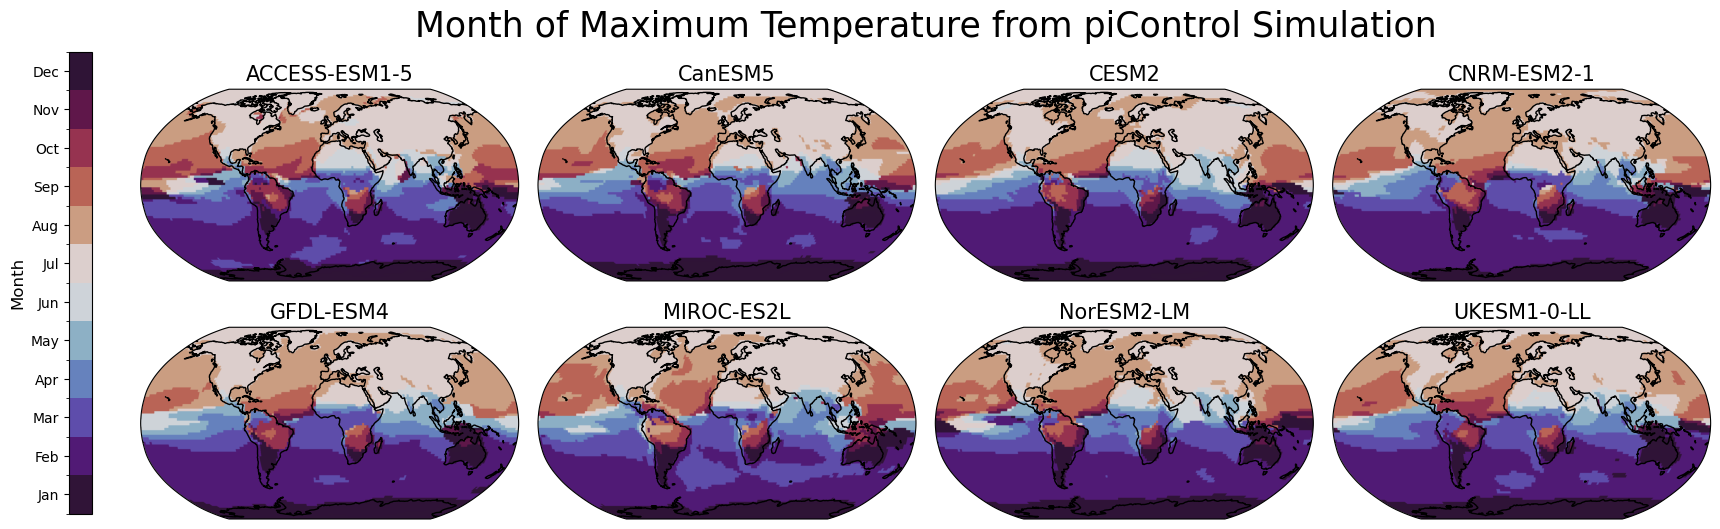

In [16]:
fig, axes = plt.subplots(2, 4, subplot_kw={"projection": ccrs.Robinson()},
                         figsize=(16, 6),
                         sharey=True)

# Define a custom colormap and ticks for months
projection = ccrs.PlateCarree()
cmap = plt.cm.twilight_shifted  # Use the 'twilight_shifted' colormap
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

boundaries = np.arange(1, 14)  # Boundaries for 12 months (1 to 13 to include the last bin edge)
norm = BoundaryNorm(boundaries, cmap.N, clip=True) 

# Configure colorbar arguments
cbar_kwargs = {"fraction": 0.06, "aspect": 20, "orientation": 'vertical', 
               'location': 'left', 'pad': 0.02,'anchor':(-5,0.5)}

for (model, dt), ax in zip(extreme_months.items(),axes.flat):
    ds = dt.ds.sel(month='max').tas
    im = ax.imshow(
        ds,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        origin='lower',
        extent=(0, 360, -90, 90)
    )
    ax.set_title(model, fontsize=15)
    ax.coastlines()

# Add a single discrete colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, boundaries=boundaries, **cbar_kwargs)
cbar.set_ticks(np.arange(1.5, 13.5))  # Center ticks within each bin
cbar.set_ticklabels(month_labels)  # Set tick labels to month names
cbar.set_label("Month", fontsize=12)
fig.suptitle("Month of Maximum Temperature from piControl Simulation", fontsize=25, y=0.95)
fig.tight_layout()

plt.show()

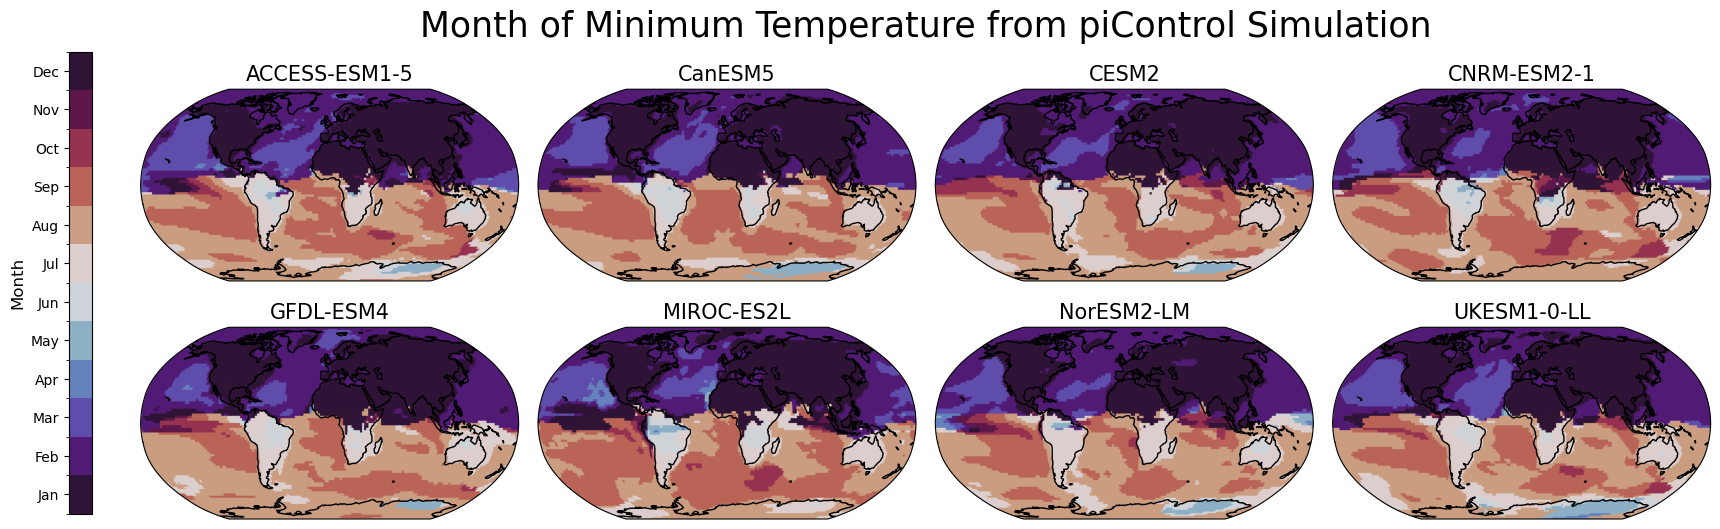

In [17]:
fig, axes = plt.subplots(2, 4, subplot_kw={"projection": ccrs.Robinson()},
                         figsize=(16, 6),
                         sharey=True)

# Define a custom colormap and ticks for months
projection = ccrs.PlateCarree()
cmap = plt.cm.twilight_shifted  # Use the 'twilight_shifted' colormap
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

boundaries = np.arange(1, 14)  # Boundaries for 12 months (1 to 13 to include the last bin edge)
norm = BoundaryNorm(boundaries, cmap.N, clip=True) 

# Configure colorbar arguments
cbar_kwargs = {"fraction": 0.06, "aspect": 20, "orientation": 'vertical', 
               'location': 'left', 'pad': 0.02,'anchor':(-5,0.5)}

for (model, dt), ax in zip(extreme_months.items(),axes.flat):
    ds = dt.ds.sel(month='min').tas
    im = ax.imshow(
        ds,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        origin='lower',
        extent=(0, 360, -90, 90)
    )
    ax.set_title(model, fontsize=15)
    ax.coastlines()

# Add a single discrete colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, boundaries=boundaries, **cbar_kwargs)
cbar.set_ticks(np.arange(1.5, 13.5))  # Center ticks within each bin
cbar.set_ticklabels(month_labels)  # Set tick labels to month names
cbar.set_label("Month", fontsize=12)
fig.suptitle("Month of Minimum Temperature from piControl Simulation", fontsize=25, y=0.95)
fig.tight_layout()

plt.show()

<b> Step 2 & Step 3: Calculate the monthly means and standard deviations for each grid cell's month of maximum temperature </b>

In [ ]:
def extrema_mean_dt(ds:xr.Dataset):
    if 'tas' in ds:
        